#  Novel Time Series Primitive that Allows Real World Classification

## Contrast Profile

The tutorial is adapted from the [Matrix Profile XXIII paper](https://www.cs.ucr.edu/~eamonn/ContrastProfile_V048_names.pdf).  

Subsequence’s distance to its nearest neighbor within the same 
dataset can be represented by the [Matrix Profile](https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html).  

Time series **motifs** refer to two particularly **close** subsequences,  
whereas time series **discords** indicate subsequences that are **far** from their nearest neighbors.  

Let's demonstrate it in ECG data with anormaly behavior.
- 1.Matrix Profile on the first half of dataset which has **1 anomaly behavior**.
- 2.Matrix Profile with whole dataset which has **2 similar anomaly behaviors**.

In [78]:
import stumpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

ecg_demo_df = pd.read_csv("ECG_demo.csv", index_col=0).astype(flsoat)
T_m = ecg_demo_df.values[:, 0]
T_p = ecg_demo_df.values[:, 1]

# 1. the first half of dataset
m = 128  # for example
MP_PP1 = stumpy.stump(T_p[:2000], m, normalize=False)
discord_idx1 = np.argmax(MP_PP1[:, 0])  # disccords
discord_nn_idx1 = MP_PP1[discord_idx1, 1]  # disccords nearest neighborhood

We will explain the concept with each of the following data that satisfy the following conditions.
- **𝐓(+)**: contains  **at  least  two  instances**  that  are  unique  to the phenomena of interest. (It also include regular, obvious patterns.)
- **𝐓(−)**: contains **zero instances of interest**.  

Take a look at the plot below to confirm the condictions.

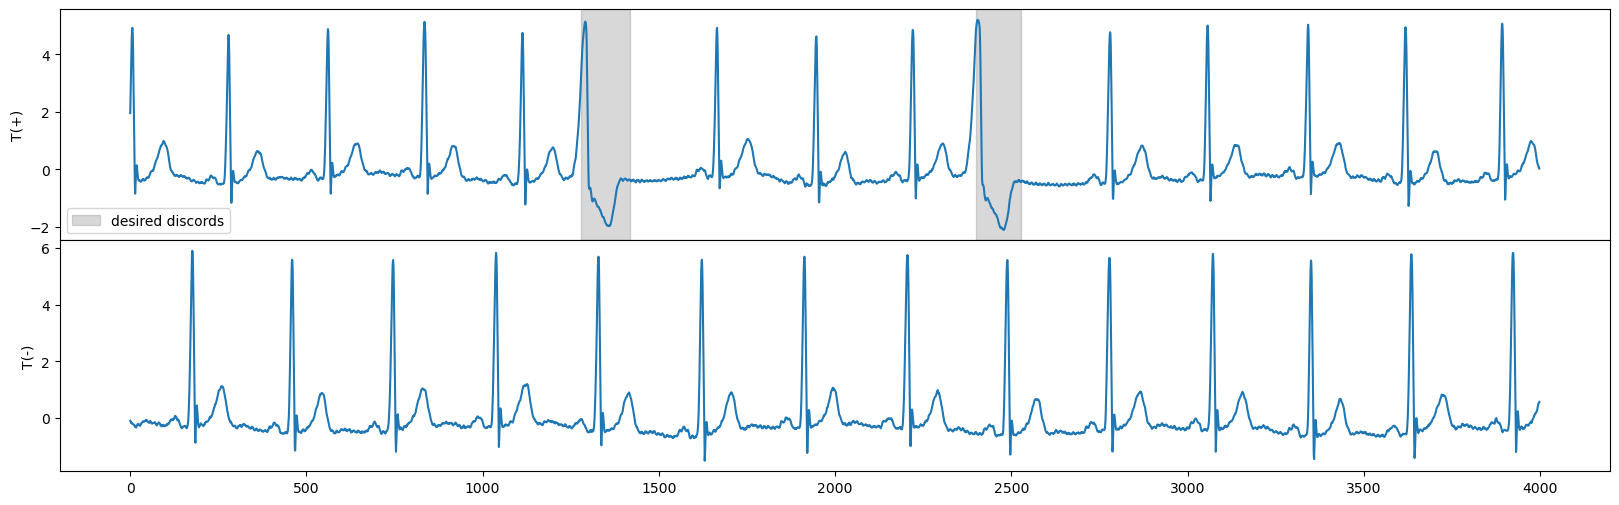

In [108]:
fig, axes=plt.subplots(2, 1, sharex=True, gridspec_kw={"hspace":0})
axes[0].axvspan(1280, 1290+m, color="grey", alpha=0.3, label="desired discords")
axes[0].axvspan(2400, 2400+m, color="grey", alpha=0.3)
axes[0].plot(T_p)
axes[1].plot(T_m)
axes[0].set_ylabel("T(+)")
axes[1].set_ylabel("T(-)")
axes[0].legend()
plt.show()

You can see two presence of novel patterns(PVCs) as discords in upper fig. Those are target we try to find.
##### 1. Matrix Profile with **the first half** of dataset (which has 1 anomaly behavior.)

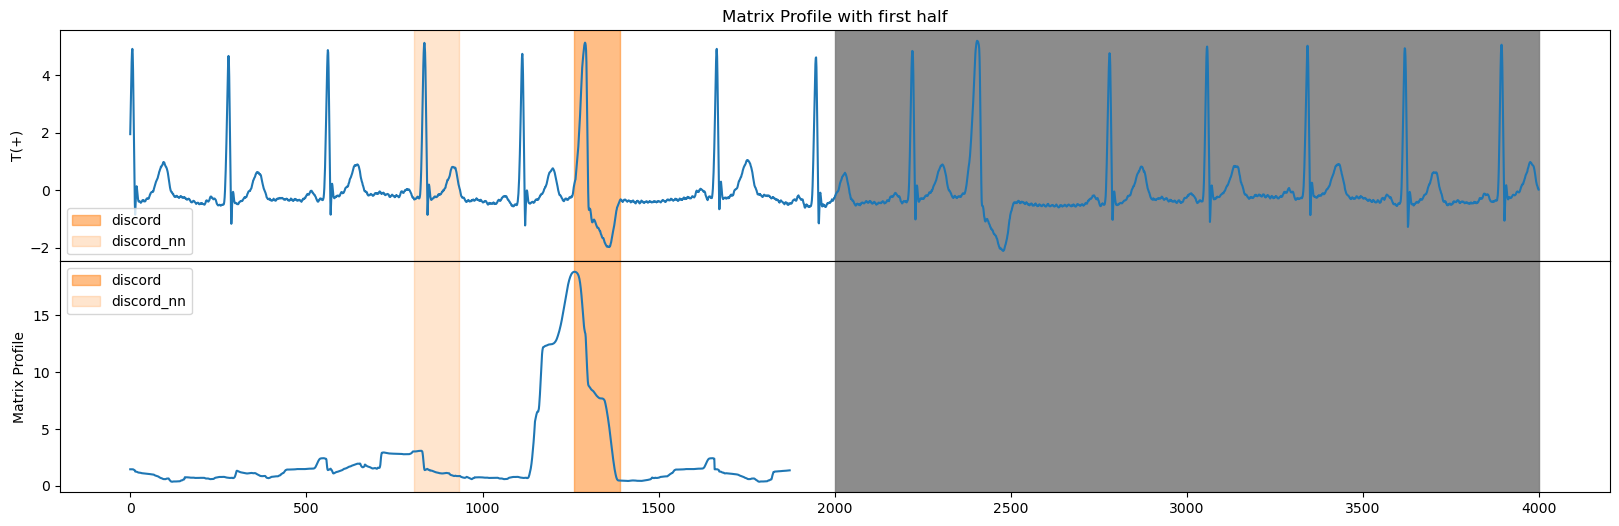

In [115]:
fig, axes=plt.subplots(2, 1, sharex=True, gridspec_kw={"hspace":0})
axes[0].axvspan(2000, 4000, color="grey", alpha=0.9)
axes[0].axvspan(discord_idx1, discord_idx1+m, color="C1", alpha=0.5, label="discord")
axes[0].axvspan(discord_nn_idx1, discord_nn_idx1+m, color="C1", alpha=0.2, label="discord_nn")
axes[0].plot(T_p)
axes[1].axvspan(2000, 4000, color="grey", alpha=0.9)
axes[1].axvspan(discord_idx1, discord_idx1+m, color="C1", alpha=0.5, label="discord")
axes[1].axvspan(discord_nn_idx1, discord_nn_idx1+m, color="C1", alpha=0.2, label="discord_nn")
axes[1].plot(MP_PP1[:, 0])
axes[0].legend()
axes[1].legend(loc=2)
axes[0].set_title("Matrix Profile with first half")
axes[0].set_ylabel("T(+)")
axes[1].set_ylabel("Matrix Profile")
plt.show()

We can find clealy the discord by Matrix profile. It indicate the discord in Matrix profile by far.
##### 2. Matrix Profile with **whole dataset** (which has 2 anomaly behaviors.)

In [63]:
# 2. whole dataset
MP_PP2 = stumpy.stump(T_p, m, normalize=False)
discord_idx2 = np.argmax(MP_PP2[:, 0])  # disccords
discord_nn_idx2 = MP_PP2[discord_idx2, 1]  # disccords nearest neighborhood

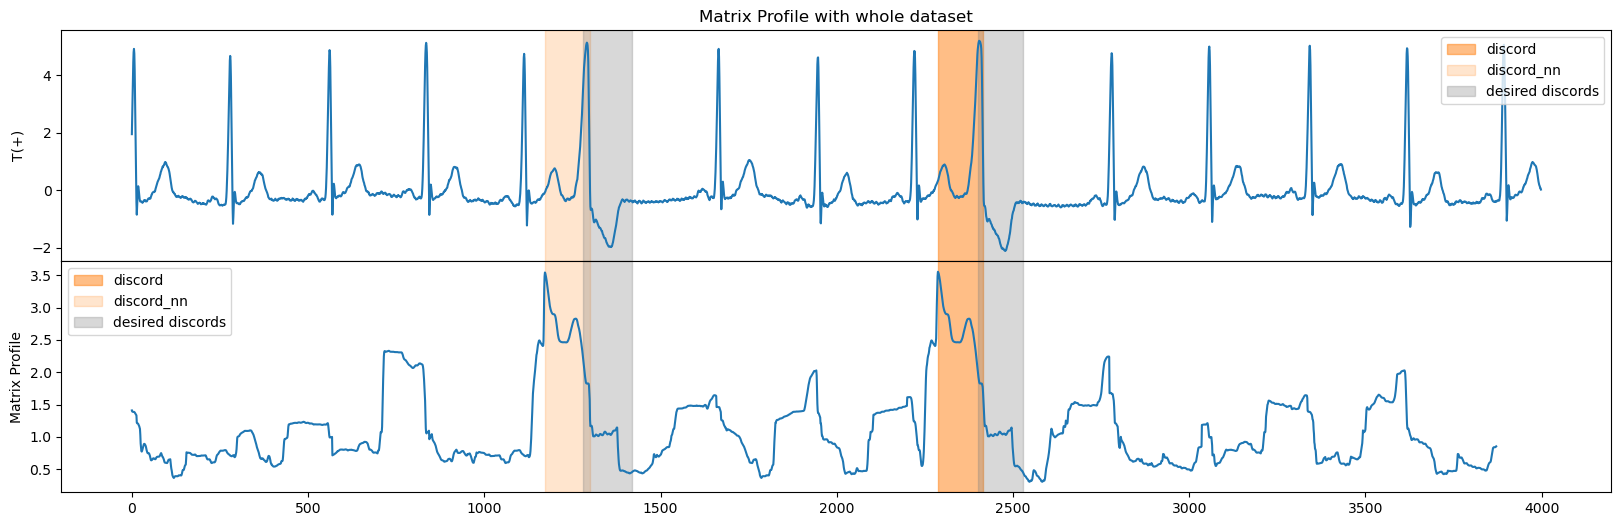

In [114]:
fig, axes=plt.subplots(2, 1, sharex=True, gridspec_kw={"hspace":0})
axes[0].axvspan(discord_idx2, discord_idx2+m, color="C1", alpha=0.5, label="discord")
axes[0].axvspan(discord_nn_idx2, discord_nn_idx2+m, color="C1", alpha=0.2, label="discord_nn")
axes[0].axvspan(1280, 1290+m, color="grey", alpha=0.3, label="desired discords")
axes[0].axvspan(2400, 2400+m, color="grey", alpha=0.3)
axes[0].plot(T_p)
axes[1].axvspan(discord_idx2, discord_idx2+m, color="C1", alpha=0.5, label="discord")
axes[1].axvspan(discord_nn_idx2, discord_nn_idx2+m, color="C1", alpha=0.2, label="discord_nn")
axes[1].axvspan(1280, 1290+m, color="grey", alpha=0.3, label="desired discords")
axes[1].axvspan(2400, 2400+m, color="grey", alpha=0.3)
axes[1].plot(MP_PP2[:, 0])
axes[0].legend()
axes[1].legend(loc=2)
axes[0].set_title("Matrix Profile with whole dataset")
axes[0].set_ylabel("T(+)")
axes[1].set_ylabel("Matrix Profile")
plt.show()

Matrix profile indicate slided wrong place as discords.   
Most important thing is Matrix profile also doesn't indicate remarkable distance for the discord.  
=> Because, desired discords have similar nearest_neighbor.

How can we find those 2 anormaly behaviors from the dataset. Those specification is followings.
1. Those have close nearest neighbor in same data **(T+)**.
2. Those is far from its nearest neighbor in **zero-instance of interest** **(T-)**.

This is exactly the property we desire.

We call this property(our interest) **Contrast**, and the vector that represents it the **Contrast Profile**.  


## Loading the ECG data
We proposed to compute the Contrast Profile **only when we belive that the two following assumptions are likely to be true:**
- 𝐓(+): contains  **at  least  two  instances**  that  are  unique  to the phenomena of interest. 
- 𝐓(−): contains **zero instances of interest**.  

We load two snippet T_pos: **T(+)** and T_neg: **T(-)**, Those are around 27-second snippet.  
Define index of desired instances on the purpose.  

In [92]:
ecg_df = pd.read_csv("ECG.csv", index_col=0).astype(float)
ecg_df.head(2)

,T(-),T(+)
0,30.0,-6.0
1,34.0,-8.0


In [90]:
T_neg = ecg_df.iloc[:, 0].values  # T(-)
T_pos = ecg_df.iloc[:, 1].values  # T(+)

m = 128
idx_desired0, idx_desired1 = 550, 2030

## Visualizing the ECG snippets with desired instances.
This dataset is ECG of 75-year-old male.  
According to the doctors that annotated this datasets. 
there are two examples of PVC premature ventricular contractions.  
Those are instances we desire to find.


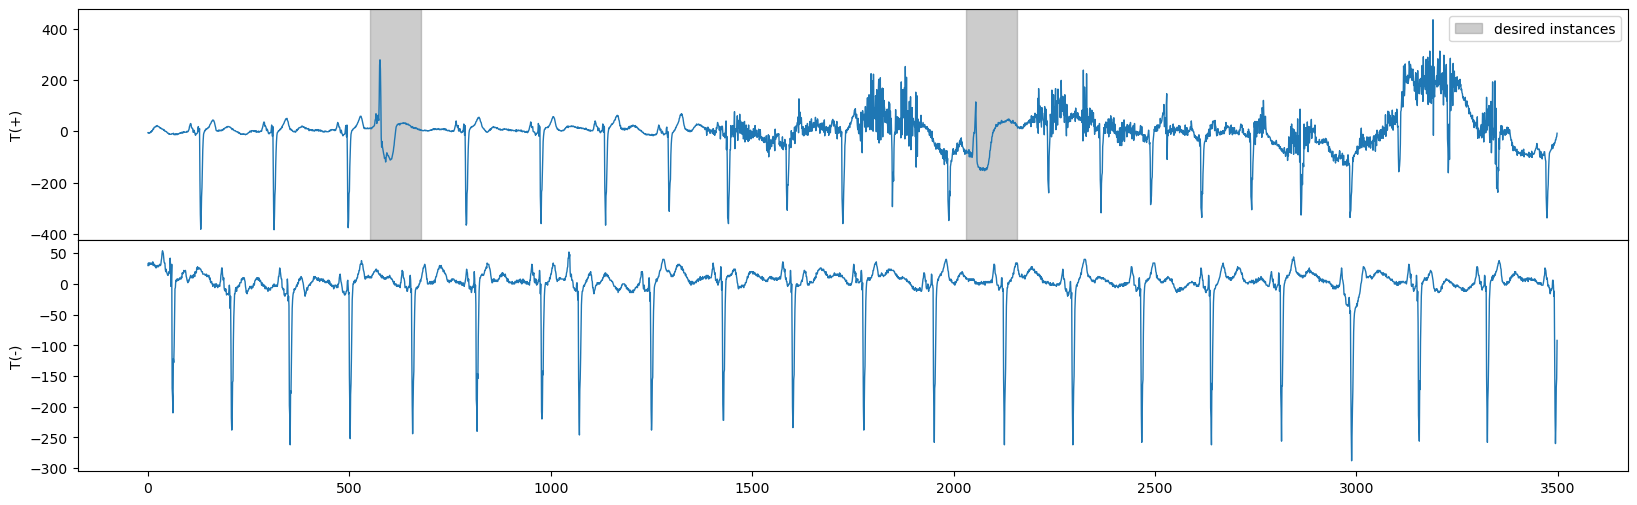

In [94]:
fig, axis = plt.subplots(2, 1, gridspec_kw={"hspace":0})
axis[0].plot(T_pos, linewidth=1)
axis[1].plot(T_neg, linewidth=1)
axis[0].axvspan(idx_desired0, idx_desired0+m, color="grey", alpha=0.4, label="desired instances")
axis[0].axvspan(idx_desired1, idx_desired1+m, color="grey", alpha=0.4)
axis[0].set_ylabel("T(+)")
axis[1].set_ylabel("T(-)")
axis[0].legend(loc=1)

plt.show()

[Upper Fig] : T(+) contains at least two instances that are of our interest.  
Signals on grey area are two "desired instances" which are similar.  

[Bottom Fig] : T(-) looks clean, much more regular repeated pattern.  
Because T(-) has to be **zero instances of interest**.

## What can Matrix Profile find?
Let's demonstrate which kind of motifs/discords self-join Matrix Profile for T(+) can find.

In [93]:
MP_PP = stumpy.stump(T_pos, m)
idx_motif = np.argmin(MP_PP[:, 0])
idx_motif_nn = MP_PP[idx_motif, 1]
idx_discord = np.argmax(MP_PP[:, 0])
idx_discord_nn = MP_PP[idx_discord, 1]

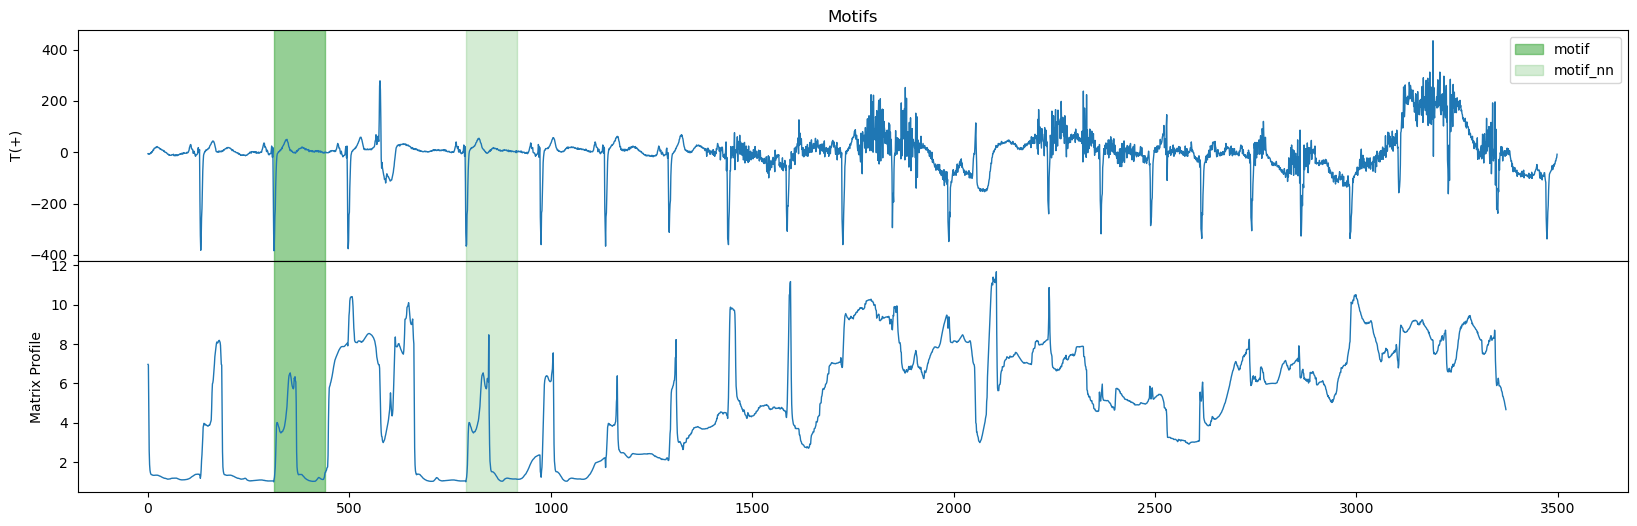

In [116]:
fig, axes = plt.subplots(2, 1, sharex=True, gridspec_kw={"hspace":0.0})
axes[0].plot(T_pos, linewidth=1)
axes[1].plot(MP_PP[:, 0], linewidth=1)

axes[0].axvspan(idx_motif, idx_motif+m, color="C2", alpha=0.5, label="motif")
axes[1].axvspan(idx_motif, idx_motif+m, color="C2", alpha=0.5)
axes[0].axvspan(idx_motif_nn, idx_motif_nn+m, color="C2", alpha=0.2, label="motif_nn")
axes[1].axvspan(idx_motif_nn, idx_motif_nn+m, color="C2", alpha=0.2)
axes[0].set_ylabel("T(+)")
axes[1].set_ylabel("Matrix Profile")
axes[0].legend(loc=1)
axes[0].set_title("Motifs")
plt.show()

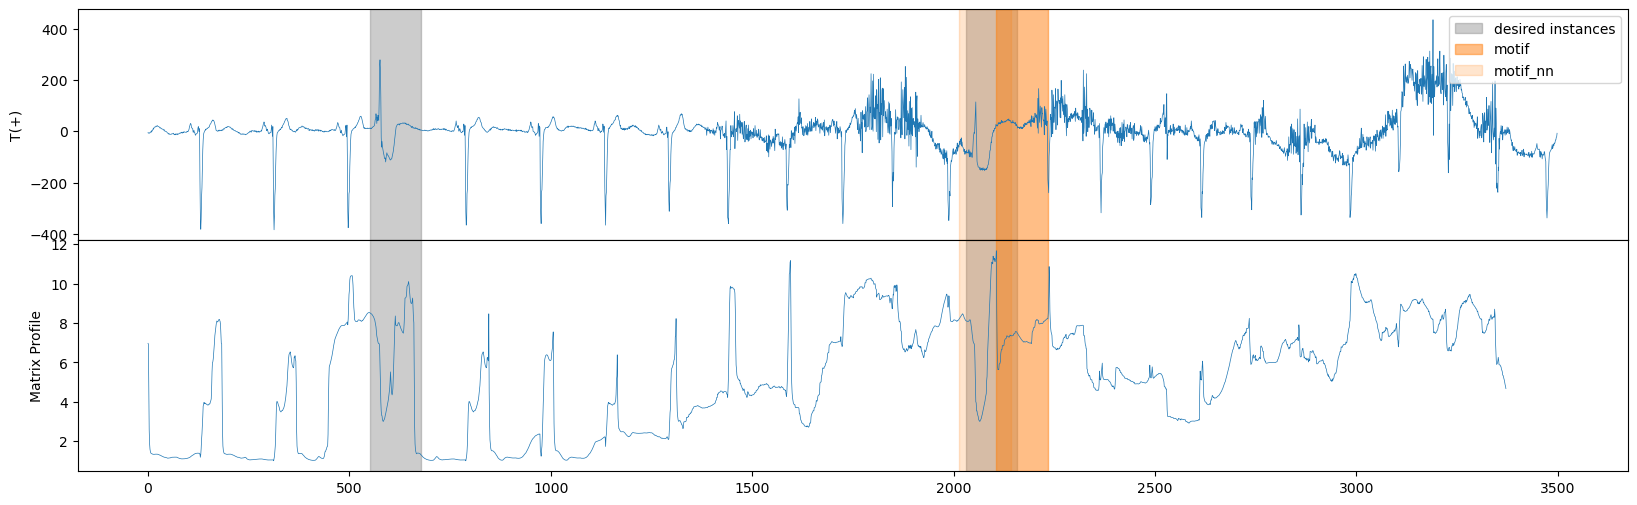

In [117]:
fig, axis = plt.subplots(2, 1, sharex=True, gridspec_kw={"hspace":0.0})
axis[0].plot(T_pos, linewidth=0.5)
axis[1].plot(MP_PP[:, 0], linewidth=0.5)
axis[0].axvspan(idx_desired0, idx_desired0+m, color="grey", alpha=0.4, label="desired instances")
axis[1].axvspan(idx_desired0, idx_desired0+m, color="grey", alpha=0.4)
axis[0].axvspan(idx_desired1, idx_desired1+m, color="grey", alpha=0.4)
axis[1].axvspan(idx_desired1, idx_desired1+m, color="grey", alpha=0.4)

axis[0].axvspan(idx_discord, idx_discord+m, color="C1", alpha=0.5, label="motif")
axis[1].axvspan(idx_discord, idx_discord+m, color="C1", alpha=0.5)
axis[0].axvspan(idx_discord_nn, idx_discord_nn+m, color="C1", alpha=0.2, label="motif_nn")
axis[1].axvspan(idx_discord_nn, idx_discord_nn+m, color="C1", alpha=0.2)
axis[0].set_ylabel("T(+)")
axis[1].set_ylabel("Matrix Profile")
axis[0].legend(loc=1)
plt.show()

While these two beats(desired instances) are similar, they are not as well conserved as normal beats.